## Generation of the map guassian covariance

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import astropy.io.fits as fits
import camb
from matplotlib.colors import LogNorm, SymLogNorm
from generate_full_covariance import *
from save_full_covariance import *


In [2]:
def generate_power_spectra_CAMB(Nside,  r=10**(-2), Alens=1, H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06, ns=0.965, lens_potential_accuracy=1, nt=0, ntrun=0, type_power='total', typeless_bool=False):
    """
    Return [Cl^TT, Cl^EE, Cl^BB, Cl^TE]
    """
    lmax = 2*Nside
    # pars = camb.CAMBparams(max_l_tensor=lmax, parameterization='tensor_param_indeptilt')
    pars = camb.CAMBparams(max_l_tensor=lmax)
    pars.WantTensors = True

    pars.Accuracy.AccurateBB = True
    pars.Accuracy.AccuratePolarization = True
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, mnu=mnu, omk=omk, tau=tau, Alens=Alens)
    pars.InitPower.set_params(As=2e-9, ns=ns, r=r, parameterization='tensor_param_indeptilt', nt=nt, ntrun=ntrun)
    pars.max_eta_k_tensor = lmax + 100  # 15000  # 100

    # pars.set_cosmology(H0=H0)
    pars.set_for_lmax(lmax, lens_potential_accuracy=lens_potential_accuracy)

    print("Calculating spectra from CAMB !")
    results = camb.get_results(pars)

    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK', raw_cl=True, lmax=lmax)    
    if typeless_bool:
        return powers
    return powers[type_power]

In [3]:
# nside = 512
nside = 64*2
camb_cls = generate_power_spectra_CAMB(nside)

Calculating spectra from CAMB !


In [4]:
nside = 64
camb_cls = camb_cls[:2*nside+1,:]

In [5]:
maps_TQU = hp.synfast(camb_cls.T,nside, new=True)

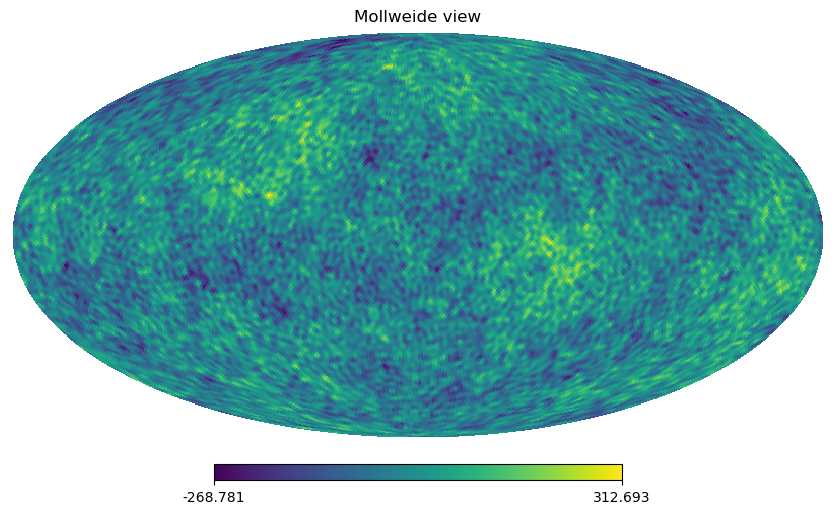

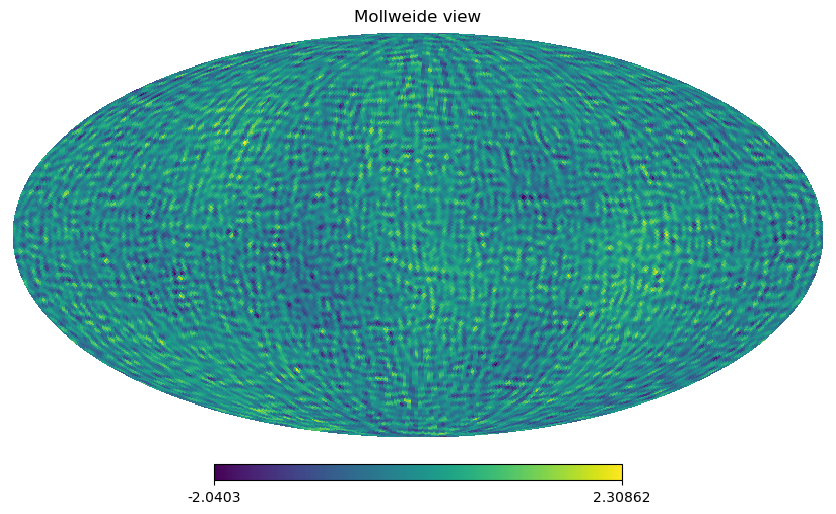

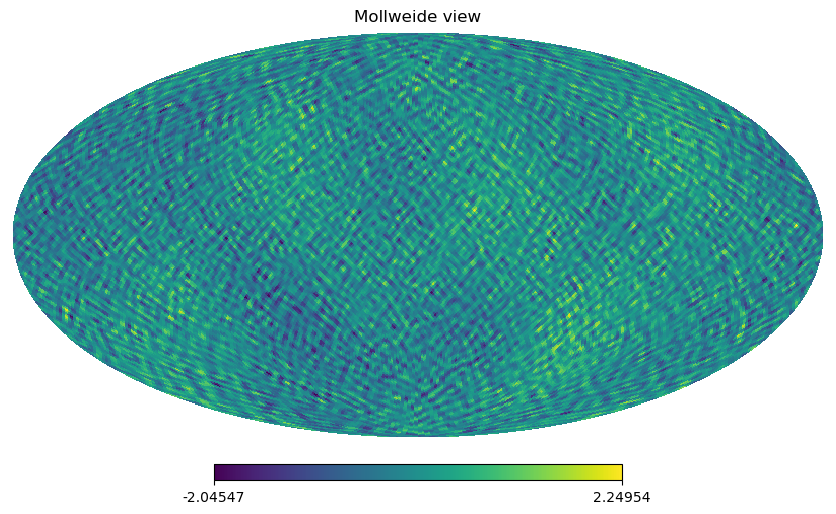

In [6]:
hp.mollview(maps_TQU[0])
hp.mollview(maps_TQU[1])
hp.mollview(maps_TQU[2])

In [7]:
def save_fits_file_from_array(array_to_save, name_column_array, directory_path='', outname=''):
    """ Save arrays with corresponding name_column_array in directory_path+outname
        Note that the first index of the array_to_save will correspond to the number of columns recorded in the fits file

        To save c_ells, the array_to_save should be a vector in 1 dimension
        name_column_array must be a list of the name of the array, even if there is only 1 array
    """
    
    print('Shape array', array_to_save.shape)
    print('Recording 3-maps in', directory_path, outname)
    if directory_path=='':
        raise Exception('NO DIRECTORY PATH GIVEN TO SAVE FITS FILE !')
    
    dimension_array = array_to_save.shape[0]

    list_hdu = [fits.PrimaryHDU(array_to_save)]
    if len(array_to_save.shape) == 1:
        list_hdu.append(fits.BinTableHDU.from_columns([fits.Column(name=name_column_array[0], array=array_to_save, format='1D')]))
    else :
        list_hdu.append(fits.BinTableHDU.from_columns([fits.Column(name=name_column_array[i], array=array_to_save[i,:], format='1D') for i in range(dimension_array)]))

    hdu_list = fits.HDUList(list_hdu)
    # Header = fits.Header()


    if directory_path[-1] != '/':
        directory_path += '/'
    endfile = ''
    if outname[-5:] != '.fits':
        endfile = '.fits'
    hdu_list.writeto(directory_path+outname+endfile,overwrite=True)

def save_map_Xpure_from_maps(maps_TQU_, directory_path='', outname=''):
    """ maps_TQU_ must have the dimension (3, 12*nside**2)
    """
    print('Shape maps TQU', maps_TQU_.shape)
    print('Recording 3-maps in', directory_path, outname)
    map_names = ['T', 'Q', 'U']
    if directory_path=='':
        raise Exception('NO DIRECTORY PATH TO SAVE !!!')
        return
    list_hdu = [fits.PrimaryHDU(maps_TQU_)]
    list_hdu.append(fits.BinTableHDU.from_columns([fits.Column(name=map_names[i], array=maps_TQU_[i,:], format='1D') for i in range(3)]))

    hdu_list = fits.HDUList(list_hdu)
    Header = fits.Header()
    endfile = ''
    if outname[-5:] != '.fits':
        endfile = '.fits'
    hdu_list.writeto(directory_path+outname+endfile,overwrite=True)


In [8]:
save_fits_file_from_array(np.ravel(camb_cls[1:,:].T, order='C'), ['cell'], directory_path='/global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/', outname='cls_limited_128')
camb_cls_woTE = np.zeros_like(camb_cls)
camb_cls_woTE[:,:3] = camb_cls[:,:3]
save_fits_file_from_array(np.ravel(camb_cls_woTE[1:,:].T, order='C'), ['cell'], directory_path='/global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/', outname='cls_limited_128_woTE')
camb_cls_woTE[:,0] = 0
save_fits_file_from_array(np.ravel(camb_cls_woTE[1:,:].T, order='C'), ['cell'], directory_path='/global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/', outname='cls_limited_128_woTTTE')
save_fits_file_from_array(np.ravel(camb_cls_woTE[1:,1:3].T, order='C'), ['cell'], directory_path='/global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/', outname='cls_limited_128_woTTTE_v2')
camb_cls_only_BB = np.zeros_like(camb_cls)
camb_cls_only_BB[:,2] = camb_cls[:,2]
save_fits_file_from_array(np.ravel(camb_cls_only_BB[1:,:].T, order='C'), ['cell'], directory_path='/global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/', outname='cls_limited_128_only_BB')
camb_cls_only_EEBB = np.zeros_like(camb_cls)
camb_cls_only_EEBB[:,1:3] = camb_cls[:,1:3]
save_fits_file_from_array(np.ravel(camb_cls_only_EEBB[1:,:].T, order='C'), ['cell'], directory_path='/global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/', outname='cls_limited_128_only_EEBB')

Shape array (512,)
Recording 3-maps in /global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/ cls_limited_128
Shape array (512,)
Recording 3-maps in /global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/ cls_limited_128_woTE
Shape array (512,)
Recording 3-maps in /global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/ cls_limited_128_woTTTE
Shape array (256,)
Recording 3-maps in /global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/ cls_limited_128_woTTTE_v2
Shape array (512,)
Recording 3-maps in /global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/ cls_limited_128_only_BB
Shape array (512,)
Recording 3-maps in /global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/ cls_limited_128_only_EEBB


In [9]:
maps_TQU = hp.synfast(camb_cls.T,nside, new=True)

path_output_map = '/global/homes/m/mag/perl_midapack/midapack/mappraiser/test_wiener_filter/'
outname = 'Map_test_band_limited_128.fits'
save_map_Xpure_from_maps(maps_TQU, directory_path=path_output_map, outname=outname)

# outname = 'Map_test_band_limited_woTE_128.fits'
# maps_TQU_woTTTE = hp.synfast(camb_cls_woTE.T,nside, new=True)
# save_map_Xpure_from_maps(maps_TQU_woTTTE, directory_path=path_output_map, outname=outname)

# camb_cls_woTE_b = np.zeros_like(camb_cls)
# camb_cls_woTE_b[:,:3] = camb_cls[:,:3]
# outname = 'Map_test_band_limited_woTE_128.fits'
# maps_TQU_woTE = hp.synfast(camb_cls_woTE_b.T,nside, new=True)
# save_map_Xpure_from_maps(maps_TQU_woTE, directory_path=path_output_map, outname=outname)

# outname = 'Map_test_band_limited_onlyEEBB_128.fits'
# maps_TQU_only_EEBB = hp.synfast(camb_cls_only_EEBB.T,nside, new=True)
# save_map_Xpure_from_maps(maps_TQU_only_EEBB, directory_path=path_output_map, outname=outname)

Shape maps TQU (3, 49152)
Recording 3-maps in /global/homes/m/mag/perl_midapack/midapack/mappraiser/test_wiener_filter/ Map_test_band_limited_128.fits
